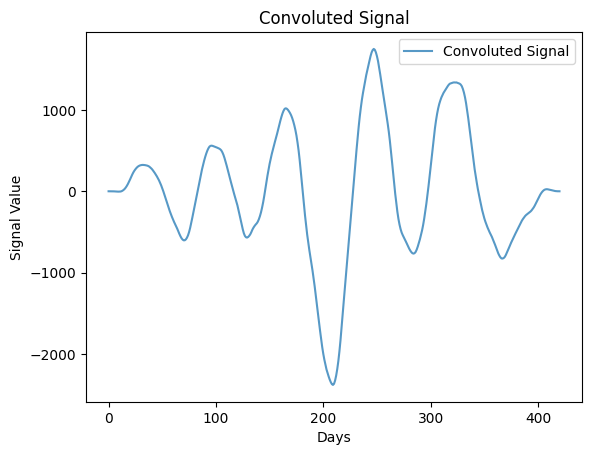

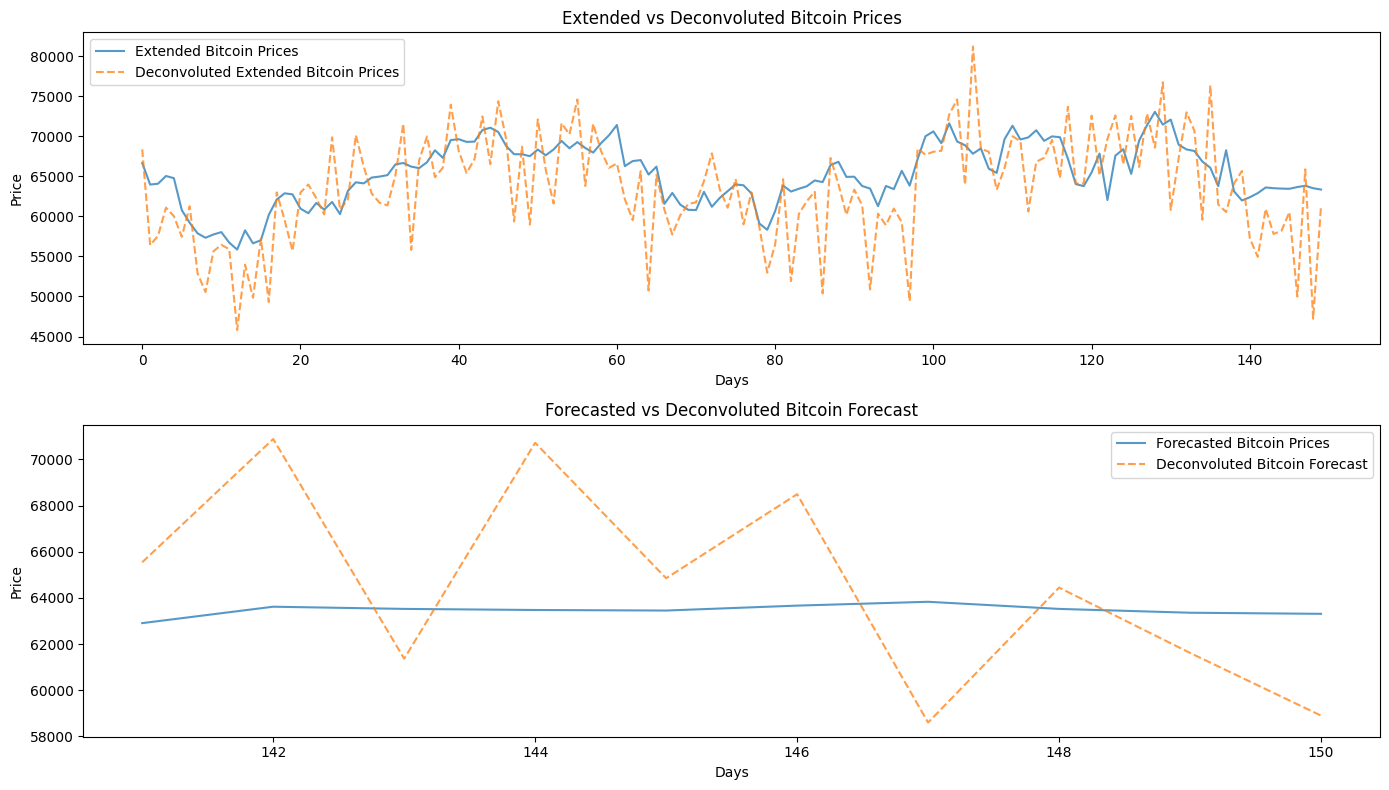

In [9]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt

# Load the datasets
ethereum_path = "/Users/diamond/chronos0724/data_files/ethereum_prices.csv"
gold_path = "/Users/diamond/chronos0724/data_files/gold_prices.csv"
bitcoin_path = "/Users/diamond/chronos0724/data_files/bitcoin_prices.csv"

ethereum_df = pd.read_csv(ethereum_path)
gold_df = pd.read_csv(gold_path)
bitcoin_df = pd.read_csv(bitcoin_path)

# Extract the 'Price' columns as numpy arrays
ethereum_prices = ethereum_df['Price'].values
gold_prices = gold_df['Price'].values
bitcoin_prices = bitcoin_df['Price'].values

# Ensure all streams are the same length by trimming/padding
min_length = min(len(ethereum_prices), len(gold_prices), len(bitcoin_prices))
ethereum_prices = ethereum_prices[:min_length]
gold_prices = gold_prices[:min_length]
bitcoin_prices = bitcoin_prices[:min_length]

# Calculate the mean and standard deviation for each series
ethereum_mean, ethereum_std = np.mean(ethereum_prices), np.std(ethereum_prices)
gold_mean, gold_std = np.mean(gold_prices), np.std(gold_prices)
bitcoin_mean, bitcoin_std = np.mean(bitcoin_prices), np.std(bitcoin_prices)

# Normalize the signals
ethereum_prices = (ethereum_prices - ethereum_mean) / ethereum_std
gold_prices = (gold_prices - gold_mean) / gold_std
bitcoin_prices = (bitcoin_prices - bitcoin_mean) / bitcoin_std

# Convolute the normalized signals
convolution_eg = np.convolve(ethereum_prices, gold_prices, mode='full')
convolution_all = np.convolve(convolution_eg, bitcoin_prices, mode='full')

plt.plot(convolution_all, label='Convoluted Signal', alpha=0.75)
plt.title("Convoluted Signal")
plt.xlabel('Days')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

# Convert the streams to tensors
ethereum_tensor = torch.tensor(ethereum_prices, dtype=torch.float32)
gold_tensor = torch.tensor(gold_prices, dtype=torch.float32)
bitcoin_tensor = torch.tensor(bitcoin_prices, dtype=torch.float32)
convolution_tensor = torch.tensor(convolution_all, dtype=torch.float32)

# Initialize the Chronos pipeline
forecast_len = 10
num_samples = 1  # Shared across all predictions
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Predict for each individual asset
ethereum_forecast = pipeline.predict(
    context=ethereum_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

gold_forecast = pipeline.predict(
    context=gold_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

bitcoin_forecast = pipeline.predict(
    context=bitcoin_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

# Predict for the convoluted signal
convolution_forecast = pipeline.predict(
    context=convolution_tensor,
    prediction_length=3*forecast_len,
    num_samples=num_samples,
)

# Convert the forecasts to numpy arrays and flatten
ethereum_forecast_values = ethereum_forecast.squeeze(0).numpy().flatten()
gold_forecast_values = gold_forecast.squeeze(0).numpy().flatten()
bitcoin_forecast_values = bitcoin_forecast.squeeze(0).numpy().flatten()
convolution_forecast_values = convolution_forecast.squeeze(0).numpy().flatten()

# Concatenate the predicted values onto the original streams
extended_ethereum = np.concatenate([ethereum_prices, ethereum_forecast_values])
extended_gold = np.concatenate([gold_prices, gold_forecast_values])
extended_bitcoin = np.concatenate([bitcoin_prices, bitcoin_forecast_values])
extended_convolution = np.concatenate([convolution_all, convolution_forecast_values])

# Recalculate the convolutions with the extended streams
extended_convolution_eg = np.convolve(extended_ethereum, extended_gold, mode='full')
#extended_convolution_all = np.convolve(extended_convolution_eg, extended_bitcoin, mode='full')
extended_convolution_all = extended_convolution

# Perform deconvolution on the extended signals to try to recover the extended Bitcoin signal
extended_convolution_fft = np.fft.fft(extended_convolution_all)
extended_convolution_eg_fft = np.fft.fft(extended_convolution_eg, n=len(extended_convolution_fft))

# Deconvolve the extended signal
retrieved_extended_bitcoin_fft = extended_convolution_fft / extended_convolution_eg_fft
retrieved_extended_bitcoin = np.fft.ifft(retrieved_extended_bitcoin_fft)

# Reverse the normalization for the deconvoluted signal
retrieved_extended_bitcoin = np.real(retrieved_extended_bitcoin) * bitcoin_std + bitcoin_mean

# Reverse the normalization for the extended Bitcoin series
extended_bitcoin = extended_bitcoin * bitcoin_std + bitcoin_mean

# Plotting the deconvoluted results
plt.figure(figsize=(14, 8))

# Original vs. Deconvoluted Bitcoin
plt.subplot(2, 1, 1)
plt.plot(extended_bitcoin[:150], label='Extended Bitcoin Prices', alpha=0.75)
plt.plot(retrieved_extended_bitcoin[:150], label='Deconvoluted Extended Bitcoin Prices', linestyle='--', alpha=0.75)
plt.title("Extended vs Deconvoluted Bitcoin Prices")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

# Forecasted vs. Deconvoluted Bitcoin Forecast
plt.subplot(2, 1, 2)
plt.plot(range(len(bitcoin_prices), len(extended_bitcoin)), bitcoin_forecast_values * bitcoin_std + bitcoin_mean, label='Forecasted Bitcoin Prices', alpha=0.75)
plt.plot(range(len(bitcoin_prices), len(extended_bitcoin)), retrieved_extended_bitcoin[-forecast_len:], label='Deconvoluted Bitcoin Forecast', linestyle='--', alpha=0.75)
plt.title("Forecasted vs Deconvoluted Bitcoin Forecast")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
help(pipeline.predict)